<a href="https://colab.research.google.com/github/tayfununal/Normalizing-Flows/blob/main/realNVP_moon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import sklearn.datasets as sklearn_data
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

tfd = tfp.distributions
tfb = tfp.bijectors

print('tensorflow: ', tf.__version__)
print('tensorflow-probability: ', tfp.__version__)

tensorflow:  2.8.0
tensorflow-probability:  0.16.0


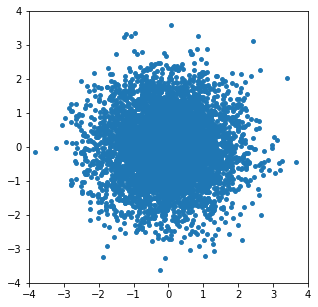

In [64]:
mvn = tfd.MultivariateNormalDiag(loc=[0., 0.], scale_diag=[1., 1.])
mvn_samples = mvn.sample(5000)
plt.figure(figsize=(5,5))
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.scatter(mvn_samples[:, 0], mvn_samples[:, 1], s=15)

In [65]:
X, _ = sklearn_data.make_moons(n_samples=10000, shuffle=True, noise=0.05, random_state=1)

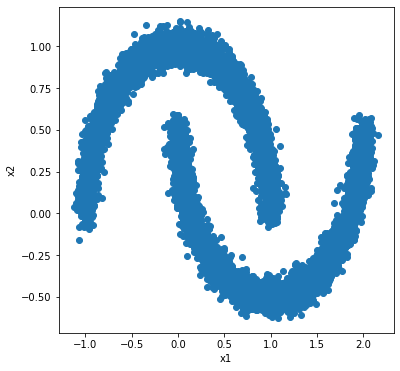

In [66]:
plt.figure(figsize=(6,6))
plt.xlabel("x1")
plt.ylabel("x2")
plt.scatter(X[:,0], X[:,1])

In [67]:
from tensorflow.keras.layers import Layer, Dense, BatchNormalization, ReLU
from tensorflow.keras import Model


class NN(Layer):
    def __init__(self, input_shape, n_hidden=[512, 512], activation="relu", name="nn"):
        super(NN, self).__init__(name="nn")
        layer_list = []
        for i, hidden in enumerate(n_hidden):
            layer_list.append(Dense(hidden, activation=activation, name='dense_{}_1'.format(i)))
            layer_list.append(Dense(hidden, activation=activation, name='dense_{}_2'.format(i)))
        self.layer_list = layer_list
        self.log_s_layer = Dense(input_shape, activation="tanh", name='log_s')
        self.t_layer = Dense(input_shape, name='t')

    def call(self, x):
        y = x
        for layer in self.layer_list:
            y = layer(y)
        log_s = self.log_s_layer(y)
        t = self.t_layer(y)
        return log_s, t


def nn_test():
    nn = NN(1, [512, 512])
    x = tf.keras.Input([1])
    log_s, t = nn(x)
    # Non trainable params: -> Batch Normalization's params
    tf.keras.Model(x, [log_s, t], name="nn_test").summary()
nn_test()

Model: "nn_test"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 1)]               0         
                                                                 
 nn (NN)                     ((None, 1),               790018    
                              (None, 1))                         
                                                                 
Total params: 790,018
Trainable params: 790,018
Non-trainable params: 0
_________________________________________________________________


In [68]:
class RealNVP(tfb.Bijector):
    def __init__(
        self,
        input_shape,
        n_hidden=[512, 512],
        # this bijector do vector wise quantities.
        forward_min_event_ndims=1,
        validate_args: bool = False,
        name="real_nvp",
    ):
        """
        Args:
            input_shape: 
                input_shape, 
                ex. [28, 28, 3] (image) [2] (x-y vector)
                          
        """
        super(RealNVP, self).__init__(
            validate_args=validate_args, forward_min_event_ndims=forward_min_event_ndims, name=name
        )

        assert input_shape[-1] % 2 == 0
        self.input_shape = input_shape
        nn_layer = NN(input_shape[-1] // 2, n_hidden)
        nn_input_shape = input_shape.copy()
        nn_input_shape[-1] = input_shape[-1] // 2
        x = tf.keras.Input(nn_input_shape)
        log_s, t = nn_layer(x)
        self.nn = Model(x, [log_s, t], name="nn")

    def _forward(self, x):
        x_a, x_b = tf.split(x, 2, axis=-1)
        y_b = x_b
        log_s, t = self.nn(x_b)
        s = tf.exp(log_s)
        y_a = s * x_a + t
        y = tf.concat([y_a, y_b], axis=-1)
        return y

    def _inverse(self, y):
        y_a, y_b = tf.split(y, 2, axis=-1)
        x_b = y_b
        log_s, t = self.nn(y_b)
        s = tf.exp(log_s)
        x_a = (y_a - t) / s
        x = tf.concat([x_a, x_b], axis=-1)
        return x

    def _forward_log_det_jacobian(self, x):
        _, x_b = tf.split(x, 2, axis=-1)
        log_s, t = self.nn(x_b)
        return log_s


def realnvp_test():
    realnvp = RealNVP(input_shape=[2], n_hidden=[512, 512])
    x = tf.keras.Input([2])
    y = realnvp.forward(x)
    print('trainable_variables :', len(realnvp.trainable_variables))
    Model(x, y, name="realnvp_test").summary()


realnvp_test()

trainable_variables : 12
Model: "realnvp_test"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 2)]          0           []                               
                                                                                                  
 tf.split_3 (TFOpLambda)        [(None, 1),          0           ['input_24[0][0]']               
                                 (None, 1)]                                                       
                                                                                                  
 nn (Functional)                [(None, 1),          790018      ['tf.split_3[0][1]']             
                                 (None, 1)]                                                       
                                                              

In [69]:
num_realnvp = 4
bijector_chain = []
for i in range(num_realnvp):
    bijector_chain.append(RealNVP(input_shape=[2], n_hidden=[256, 256]))
    bijector_chain.append(tfp.bijectors.Permute([1, 0]))

flow = tfd.TransformedDistribution(
    distribution=mvn,
    bijector=tfb.Chain(list(reversed(bijector_chain)))
)
print('trainable_variables: ', len(flow.bijector.trainable_variables))

trainable_variables:  48


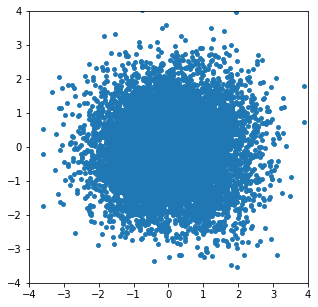

In [70]:
samples = flow.sample(10000)
plt.figure(figsize=(5, 5))
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.scatter(samples[:, 0], samples[:, 1], s=15)

In [71]:
X = tf.convert_to_tensor(X, dtype=tf.float32)
X

<tf.Tensor: shape=(10000, 2), dtype=float32, numpy=
array([[ 2.0081217 ,  0.4720392 ],
       [-0.727492  ,  0.70568347],
       [-1.0107832 , -0.01085655],
       ...,
       [ 0.78963846,  0.45781288],
       [ 0.01755504,  0.33548075],
       [ 0.9665695 ,  0.21013594]], dtype=float32)>

tf.Tensor(-444.94592, shape=(), dtype=float32)
tf.Tensor(-2.5005248, shape=(), dtype=float32)
(10000, 10000)


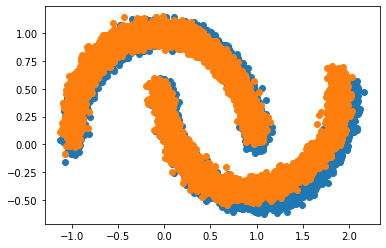

In [72]:
print(tf.reduce_sum(flow.bijector.inverse_log_det_jacobian(X, event_ndims=1)))
res = flow.bijector.inverse(X)
print(tf.reduce_mean(flow.log_prob(res)))
print(flow.log_prob(res).shape)
X.shape
plt.scatter(X[:,0], X[:,1])
plt.scatter(res[:, 0], res[:,1])

In [73]:
@tf.function
def loss(targets):
    return - tf.reduce_mean(flow.log_prob(targets))


optimizer = tf.optimizers.Adam(learning_rate=1e-4) 
log = tf.summary.create_file_writer('checkpoints')
avg_loss = tf.keras.metrics.Mean(name='loss', dtype=tf.float32)

In [74]:
n_epochs = 2

for epoch in range(n_epochs):
    for targets in X:
        with tf.GradientTape() as tape:
            log_prob_loss = loss(X)
        grads = tape.gradient(log_prob_loss, flow.trainable_variables)
        optimizer.apply_gradients(zip(grads, flow.trainable_variables))
        avg_loss.update_state(log_prob_loss)
        if tf.equal(optimizer.iterations % 100, 0):
            with log.as_default():
                tf.summary.scalar("loss", avg_loss.result(), step=optimizer.iterations)
                print(
                    "Step {} Loss {:.6f}".format(
                        optimizer.iterations, avg_loss.result()
                    )
                )
                avg_loss.reset_states()

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=100> Loss 1.773796
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=200> Loss 1.194910
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=300> Loss 0.822211
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=400> Loss 0.664700
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=500> Loss 0.610136
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=600> Loss 0.566509
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=700> Loss 0.495225
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=800> Loss 0.456527
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=900> Loss 0.435093
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=1000> Loss 0.423909
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=1100> Loss 0.416588
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=1200> Loss 0.410524
Step <tf.Variable 'Adam/iter:0' shape=() dtype=in

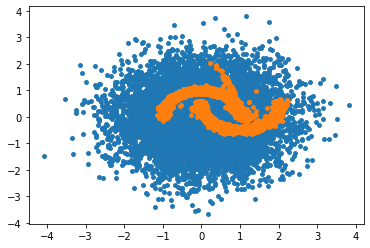

In [75]:
base = flow.distribution.sample(10000)
targets = flow.sample(10000)
plt.scatter(base[:, 0], base[:, 1], s=15)
plt.scatter(targets[:, 0], targets[:, 1], s=15)

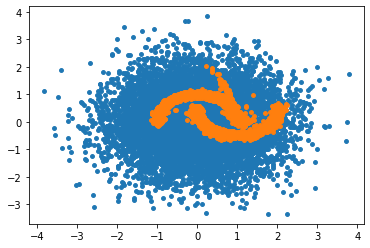

In [76]:
base = flow.bijector.inverse(targets)
targets.shape
plt.scatter(base[:, 0], base[:,1], s=15)
plt.scatter(targets[:,0], targets[:,1], s=15)